In [97]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
# Pobranie baz danych 
genres_raw = pd.read_csv('tmdb_genres.csv', index_col=0)
movies_raw = pd.read_csv('tmdb_movies.csv', index_col=0)

In [99]:
# Podgląd baz
print(genres_raw.index)
print(movies_raw.columns)

Index([   28.0,    12.0,    14.0,    16.0,   878.0,    18.0,    53.0, 10751.0,
          35.0,    36.0, 10752.0,    37.0, 10749.0,    80.0,  9648.0,    27.0,
          99.0, 10402.0, 10770.0,     nan, 10769.0],
      dtype='float64')
Index(['budget', 'homepage', 'id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'revenue', 'runtime',
       'status', 'tagline', 'title', 'vote_average', 'vote_count', 'genre_id'],
      dtype='object')


Baza filmów zawiera kolumnę z id gatunku (genre_id). \
Na tej podstawie połącz ze sobą bazę filmów z bazą gatunków, 
tak aby w bazie filmów można było odczytać nazwę gatunku filmu.

In [100]:
# Zmiana indeksu bazy gatunków w celu połączenia tabel
genres_raw.reset_index(inplace=True)
genres_raw.rename(columns={'index': 'genre_id'}, inplace=True)

In [101]:
# podgląd
print(genres_raw.columns)
print(movies_raw.columns)

Index(['genre_id', 'genres'], dtype='object')
Index(['budget', 'homepage', 'id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'revenue', 'runtime',
       'status', 'tagline', 'title', 'vote_average', 'vote_count', 'genre_id'],
      dtype='object')


In [102]:
# tabele są gotowe do połączenia, genre_id można usunąć
# połączenie tabel na kolumnie 'genre_id'
df = movies_raw.merge(genres_raw, on=['genre_id'])
df.drop(['genre_id'], axis=1, inplace=True)

# zmiana daty na format datetime
df.release_date = pd.to_datetime(df.release_date)

# podgląd
print(df.columns)

Index(['budget', 'homepage', 'id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'revenue', 'runtime',
       'status', 'tagline', 'title', 'vote_average', 'vote_count', 'genres'],
      dtype='object')


In [103]:
'''
Zwróć listę 10 najwyżej ocenianych filmów (vote_average), których liczba głosów (vote_count) 
jest większa od 3. kwartyla rozkładu liczby głosów.
'''

# utworzenie tabeli
top_movies = df[['title','original_language','vote_count', 'vote_average']][df.vote_count > df.vote_count.quantile(0.75)]\
      .sort_values(by=['vote_average'], ascending=False).copy().head(10)

# reset indeksu
top_movies.reset_index(drop=True, inplace=True)

top_movies

,title,original_language,vote_count,vote_average
0,The Shawshank Redemption,en,8205,8.5
1,The Godfather,en,5893,8.4
2,The Godfather: Part II,en,3338,8.3
3,Fight Club,en,9413,8.3
4,Spirited Away,ja,3840,8.3
5,Schindler's List,en,4329,8.3
6,Whiplash,en,4254,8.3
7,Pulp Fiction,en,8428,8.3
8,The Green Mile,en,4048,8.2
9,Princess Mononoke,ja,1983,8.2


In [104]:
top_movies['title'].to_list()

['The Shawshank Redemption',
 'The Godfather',
 'The Godfather: Part II',
 'Fight Club',
 'Spirited Away',
 "Schindler's List",
 'Whiplash',
 'Pulp Fiction',
 'The Green Mile',
 'Princess Mononoke']

Pogrupuj tabelę w taki sposób, aby otrzymać średni przychód (revenue) 
oraz średni budżet (budget) w danym roku dla filmów opublikowanych od 2010 (włącznie) do 2016 roku (włącznie). 
Następnie na tej podstawie stwórz wykres, w którym średnie przychody są wykresem kolumnowym, 
a średni budżet wykresem liniowym na tych samych osiach. Sformatuj odpowiednio oś X oraz oś Y. 
Dodaj tytuł wykresu, oraz legendę, która znajduje się w prawym górnym rogu płótna, lecz poza obszarem osi. 

In [105]:
# wyodrębnienie z bazy filmów z okresu 2010-2016
data_201016 = df[(df.release_date.dt.year >= 2010) & (df.release_date.dt.year <= 2016)].copy()
data_201016['release_year'] = data_201016.release_date.dt.year
data_201016.drop(['release_date'], axis=1, inplace=True)

data_201016_grouped = data_201016[['release_year', 'budget', 'revenue']].groupby(['release_year']).mean()
data_201016_grouped.reset_index(inplace=True)
# data_201016_grouped['budget'] = data_201016_grouped['budget'].apply(lambda x: '{:2.1f}'.format(x))
# data_201016_grouped['revenue'] = data_201016_grouped['revenue'].apply(lambda x: '{:2.1f}'.format(x))
data_201016_grouped

,release_year,budget,revenue
0,2010,3.449541e+07,9.043811e+07
1,2011,3.477232e+07,9.200413e+07
2,2012,3.492203e+07,1.160659e+08
3,2013,3.552329e+07,1.013485e+08
4,2014,3.095989e+07,1.013466e+08
5,2015,3.113216e+07,1.054399e+08
6,2016,4.570327e+07,1.390496e+08


In [106]:
def plots_1():

      def as_millions(value, pos):
            return '$ {:2.1f}M'.format(value*1e-06)

      fig, ax = plt.subplots(figsize=(8,5))

      formatter = plt.FuncFormatter(as_millions)
      ax.plot(data_201016_grouped['release_year'], data_201016_grouped['budget'], 
              zorder=1, 
              color='mediumblue', linewidth=2,
              marker = 's', markersize = 5,
              label = 'budget')
      ax.bar(data_201016_grouped['release_year'], data_201016_grouped['revenue'], 
             zorder=0, 
             color='hotpink', alpha = 0.5,
             edgecolor = 'darkviolet',
             label='revenues')
      
      ax.set_facecolor('lightgray')
      ax.yaxis.set_major_formatter(formatter)
      ax.yaxis.set_major_locator(plt.MultipleLocator(2.5e7))
      
      ax.set_xlabel('rok', loc='center', fontsize=14)
      ax.set_ylabel('kwota', loc='center', fontsize=14)
      
      plt.title('Średni przychód i budżet filmów w latach 2010-2016')
      plt.legend(loc='upper left',bbox_to_anchor=[1,1], fontsize=10)
      plt.show()

In [107]:
def plots_2():

      def as_millions(value, pos):
            return '$ {:2.1f}M'.format(value*1e-06)

      fig, ax = plt.subplots(figsize=(5,5))

      formatter = plt.FuncFormatter(as_millions)
      ax.bar(data_201016_grouped['release_year'], data_201016_grouped['budget'], 
              zorder=1, 
              width=-0.25,
              align='edge',
              color='mediumblue',
              label = 'budget')
      ax.bar(data_201016_grouped['release_year'], data_201016_grouped['revenue'], 
             zorder=0, 
             width=0.25,
             align='edge',
             color='hotpink', alpha = 0.5,
             edgecolor = 'darkviolet',
             label='revenues')
      
      ax.set_facecolor('lightgray')
      ax.yaxis.set_major_formatter(formatter)
      ax.yaxis.set_major_locator(plt.MultipleLocator(2.5e7))
      
      ax.set_xlabel('rok', loc='center', fontsize=14)
      ax.set_ylabel('kwota', loc='center', fontsize=14)
      
      plt.title('Średni przychód i budżet filmów w latach 2010-2016')
      plt.legend(loc='upper left',bbox_to_anchor=[1,1], fontsize=10)
      plt.show()

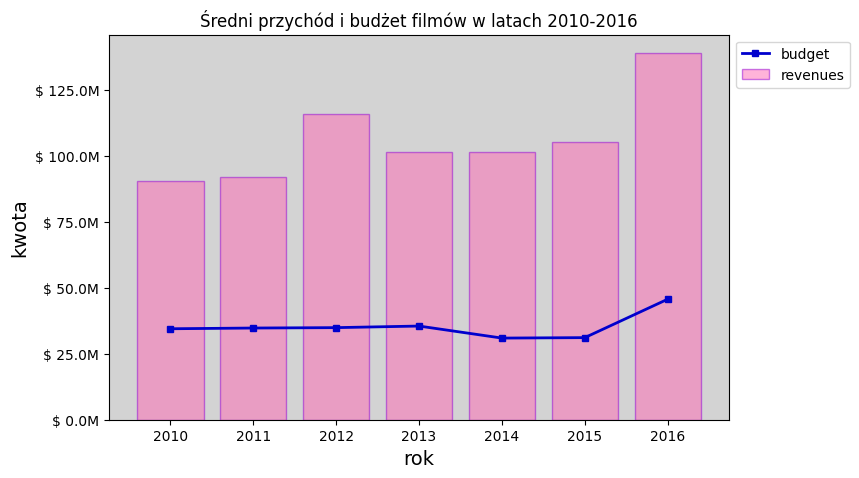

In [108]:
plots_1()

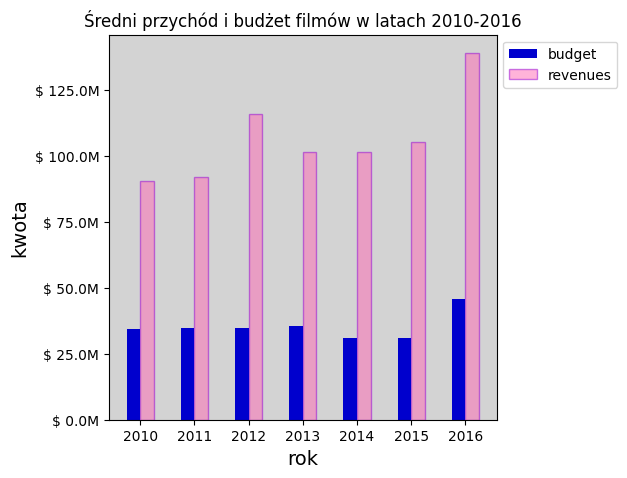

In [109]:
plots_2()

Jaki gatunek filmu z bazy pojawia się w niej najczęściej? Ile filmów tego gatunku znajduje się w bazie?

In [110]:
genres_mode = str(df.genres.mode(dropna=True)[0])
print(f'Most frequent genre is {genres_mode}')

print(
      f'There are {df.genres[df.genres==genres_mode].value_counts()[0]} movies categorized as {genres_mode} in the database.'
)

Most frequent genre is Drama
There are 1207 movies categorized as Drama in the database.


Filmy, którego gatunku trwają średnio najdłużej (runtime)?

In [111]:
df.index = df.genres

max_mean_runtime = df[['runtime']].groupby(['genres']).mean().max()[0]
print(f'{max_mean_runtime = } minutes')

# lista gatunków według średniego czasu trwania
print(df[['runtime']].groupby(['genres']).mean().sort_values(by=['runtime'],ascending=False).reset_index().head())

# tu jeszcze potrzeba wyciągnąć ten gatunek
longest_genre = df[['runtime']].groupby(['genres']).mean().sort_values(by=['runtime'],ascending=False).reset_index().iloc[0]['genres']

print(f'The genres with max average runtime is {longest_genre}')

print(
      f'There are {df.genres[df.genres==longest_genre].value_counts()[0]} movies categorized as {longest_genre} in the database.'
)

max_mean_runtime = 133.96 minutes
      genres     runtime
0    History  133.960000
1        War  126.125000
2    Western  117.925926
3      Drama  115.521559
4  Adventure  113.061947
The genres with max average runtime is History
There are 25 movies categorized as History in the database.


Stwórz histogram czasu trwania filmów z gatunku, który cechuje się największym średnim czasem trwania.

In [113]:
df_hist = df[['budget','runtime','title']].loc[longest_genre]
numbins = df_hist['runtime'].value_counts().sum()

In [116]:
def plots_3():
      fig, ax = plt.subplots(figsize=(5,5))
      df_hist['runtime'].hist(
            bins=numbins,
            grid=False,
            ax=ax,
            color='pink',
            edgecolor='red')
      ax.set_facecolor('lightgray')
      
      ax.set_xlabel('czas trwania filmu')
      ax.set_ylabel('liczba')

      plt.title(f'Czas trwania filmów z gatunku {longest_genre}')

      plt.show()

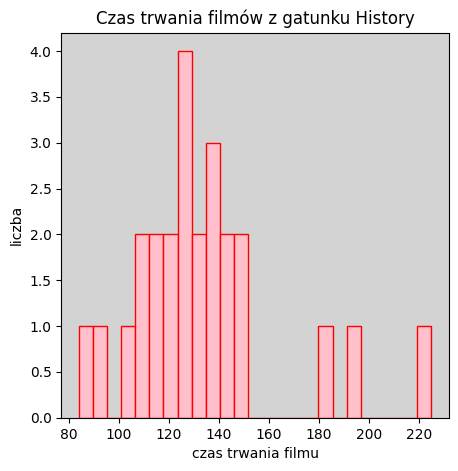

In [117]:
plots_3()